This script is based on Curved Origami by Ekaterina Likasheva. The terminology from that book is used to build generic tesselation style curves, obeying the rules (as I understand them) from the book. I suspect there is some additional mathematics that I am unaware of (but would be interested in knowing).

In [262]:
from math import *
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import collections  as mc
from matplotlib.patches import Ellipse, Wedge, Polygon
from matplotlib.path import Path
import matplotlib
import itertools

from scipy.spatial import distance
from scipy import signal


In [244]:
class curve_kernel():
  def __init__(self, angle = 60.0, horiz_d = 1.0, curve_h_of_c = 0.66, N=100, std=50):
    if (angle < 20.0) or (angle > 70.0): 
      print("WARNING: CAB angle {} should be between 20 and 70 degrees".format(angle))

    self.angle = angle;
    self.horiz_d = horiz_d
    self.curve_h_of_c = curve_h_of_c
    self.a = [0,0]
    self.mid = [horiz_d/2,0]
    self.c = [horiz_d/2, tan(radians(angle))*horiz_d/2]
    
    curve_x = np.arange(0, horiz_d,horiz_d/N)
    curve_y = signal.gaussian(N, std)
    curve_y -= min(curve_y)
    curve_y *= curve_h_of_c/max(curve_y) 
    self.curve = np.array([curve_x[0:floor(N/2)], curve_y[0:floor(N/2)]])
    self.offset = self.curve[0,-1] #+ horiz_d/N

  def __repr__(self):
    plt.plot(self.curve[0,:], self.curve[1,:])
    print("Distance a to c: {:2.2}".format(distance.euclidean(self.a, self.c)))
    return ("Angle {}, d {}, A {}, B {}, C {}".format(self.angle, self.horiz_d,
                                                    self.a, self.mid, self.c))

class curves():
  def __init__(self, kernel):
    self.kernel = kernel.curve
    self.offset = kernel.curve[0,-1]
    self.h      = max(kernel.curve[1,:])
    self.len    = 2*len(kernel.curve[1,:])

    self.a_curve = self.concatenate(first = self.kernel, 
                                    second = self.reverse(self.kernel))

    self.b_curve = self.concatenate(first = self.negative(self.reverse(self.kernel)), 
                                    second = self.kernel)

    c = self.yoffset(self.kernel, -self.h)
    self.c_curve = self.concatenate(first = c, 
                                    second = self.negative(self.reverse(c)))
    
  def yoffset(self, curve, offset):
    curve = np.copy(curve)
    curve[1,:] += offset
    return curve

  def negative(self, curve):
    curve = np.array([curve[0,:], -curve[1,:]])
    return curve

  def reverse(self, curve):
    curve = np.array([curve[0,:], np.flip(curve[1,:])])
    return curve

  def roll(self, curve, rollby):
    curve = np.copy(curve)
    curve[1,:] = np.roll(curve[1,:], rollby)
    return curve

  def concatenate(self, first, second):
    if first is None:
      return second
    xoffset = first[0,-1]
    second = np.copy(second)
    second[0,:] += xoffset
    return(np.concatenate((first, second), axis=1))

  def __repr__(self):
    plt.plot(self.kernel[0,:], self.kernel[1,:], 'k.')
    plt.plot(self.a_curve[0,:], self.a_curve[1,:], 'r')
    plt.plot(self.b_curve[0,:], self.b_curve[1,:], 'b')
    plt.plot(self.c_curve[0,:], self.c_curve[1,:], 'c')
    return ""


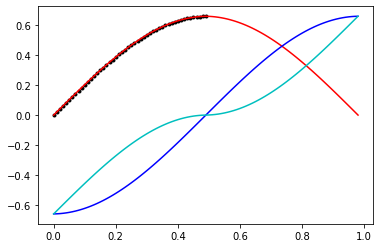

In [245]:
ckernel = curve_kernel(60.0)
cvs = curves(ckernel)
print(cvs)

In [251]:

def A_curve(curve, cvs, mult):
  return cvs.concatenate(curve, mult*np.copy(cvs.a_curve))
def a_curve(curve, cvs, mult):
  return cvs.concatenate(curve, mult*cvs.yoffset(cvs.a_curve, -cvs.h))
def B_curve(curve, cvs, mult):
  return cvs.concatenate(curve, mult*np.copy(cvs.b_curve))
def b_curve(curve, cvs, mult):
  return cvs.concatenate(curve, mult*cvs.reverse(cvs.b_curve))
def C_curve(curve, cvs, mult):
  return cvs.concatenate(curve, mult*np.copy(cvs.c_curve))
def c_curve(curve, cvs, mult):
  return cvs.concatenate(curve, mult*cvs.reverse(cvs.c_curve))
def U_curve(curve, cvs, mult):
  return cvs.concatenate(curve, mult*cvs.negative(np.copy(cvs.a_curve)))
def u_curve(curve, cvs, mult):
  return cvs.concatenate(curve, mult*cvs.negative(cvs.yoffset(cvs.a_curve, -cvs.h)))


def pipe_curve(curve, cvs, mult):
  pipe = np.array([[0,0],[0,cvs.h]])
  return cvs.concatenate(curve, mult*pipe)

def rollhalf(cvs):
  return floor(cvs.len/2)

def color_red():
  return 'r-'
def color_blue():
  return 'b-'

interpret_curve = {
    "A"   : A_curve,
    "a"   : a_curve,
    "B"   : B_curve,
    "b"   : b_curve,
    "C"   : C_curve,
    "c"   : c_curve,
    "U"   : U_curve,
    "u"   : u_curve,
    
    "|"   : pipe_curve
}

special = {
    "o"   : rollhalf

}

colors = {
    "red" : color_red,
    "blue": color_blue,
}

def interpret_line(line):
  elements = line.split()
  curve = None
  color = 'k'
  rollby = 0
  for e in elements:
    if e in special:
      rollby = special[e](cvs)
    elif e in colors:
      color = colors[e]()
    elif e[0] in interpret_curve:
      mult = 1.0
      if len(e) > 1:
        mult = float(e[1:])
      curve = interpret_curve[e[0]](curve, cvs, mult)
  curve = cvs.roll(curve, rollby)
  return color, curve


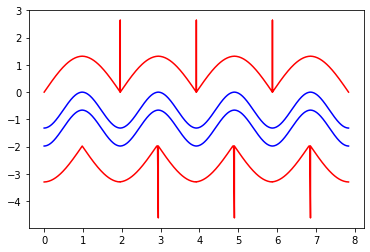

In [252]:
yoffset = 0
color, curve=interpret_line("red A2 |4 A2 |4 A2 |4 A2")
curve = cvs.yoffset(curve, yoffset)
plt.plot(curve[0,:], curve[1,:], color)

color, curve=interpret_line("blue  B b B b B b B b")
yoffset -= cvs.h
curve = cvs.yoffset(curve, yoffset)
plt.plot(curve[0,:], curve[1,:], color)

color, curve=interpret_line("blue  B b B b B b B b")
yoffset -= cvs.h
curve = cvs.yoffset(curve, yoffset)
plt.plot(curve[0,:], curve[1,:], color)

color, curve=interpret_line("red o U2 |-4 U2 |-4 U2 |-4 U2")
yoffset -= cvs.h
curve = cvs.yoffset(curve, yoffset)
plt.plot(curve[0,:], curve[1,:], color)


(2, 406)
0 7.8204 -4.484700000000001 2.7027


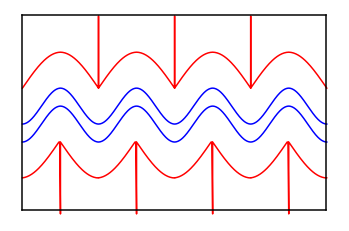

In [291]:
name = "testone"

yoffset = 0.0
color, curve=interpret_line("red A2 |4 A2 |4 A2 |4 A2")
curve = cvs.yoffset(curve, yoffset)
print(curve.shape)
plt.plot(curve[0,:], curve[1,:], color)

color, curve=interpret_line("blue  B b B b B b B b")
yoffset -= cvs.h
curve = cvs.yoffset(curve, yoffset)
plt.plot(curve[0,:], curve[1,:], color)

color, curve=interpret_line("blue  B b B b B b B b")
yoffset -= cvs.h
curve = cvs.yoffset(curve, yoffset)
plt.plot(curve[0,:], curve[1,:], color)

color, curve=interpret_line("red o U2 |-4 U2 |-4 U2 |-4 U2 |-4")
yoffset -= cvs.h
curve = cvs.yoffset(curve, yoffset)
plt.plot(curve[0,:], curve[1,:], color,)
plt.axis('tight')

#plt.axis('scaled')
plt.axis('off')
#plt.box(True)
#plt.clip_on()
xmini, xmaxi, ymini, ymaxi = plt.axis()
xmini = 0
xmaxi *= .95
ymini *= .9
ymaxi *= .9

print(xmini, xmaxi, ymini, ymaxi)


plt.plot([xmini, xmini], [ymini,ymaxi], 'k' )
plt.plot([xmaxi, xmaxi], [ymini,ymaxi], 'k' )
plt.plot([xmini, xmaxi], [ymini,ymini], 'k' )
plt.plot([xmini, xmaxi], [ymaxi,ymaxi], 'k' )
plt.savefig(name + ".svg")



In [230]:
len(kernel.curve)

50

50


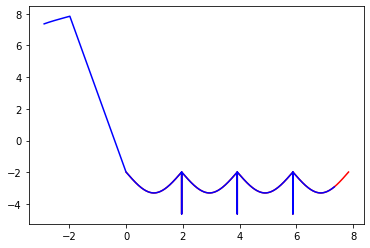

In [152]:
d = np.roll(curve, floor(len(cvs.a_curve[1,:])/4))
plt.plot(curve[0,:], curve[1,:], 'r')
plt.plot(d[0,:], d[1,:], 'b')
print(floor(len(cvs.a_curve[1,:])/2))

c
[[ 0  1  2  3  4  5]
 [ 1  2  4  6  8 10]]
d
[[ 0  1  2  3  4  5]
 [ 8 10  1  2  4  6]]


In [163]:
curve 

array([[ 0.        ,  0.        ,  0.02      ,  0.04      ,  0.06      ,
         0.08      ,  0.1       ,  0.12      ,  0.14      ,  0.16      ,
         0.18      ,  0.2       ,  0.22      ,  0.24      ,  0.26      ,
         0.28      ,  0.3       ,  0.32      ,  0.34      ,  0.36      ,
         0.38      ,  0.4       ,  0.42      ,  0.44      ,  0.46      ,
         0.48      ,  0.5       ,  0.52      ,  0.54      ,  0.56      ,
         0.58      ,  0.6       ,  0.62      ,  0.64      ,  0.66      ,
         0.68      ,  0.7       ,  0.72      ,  0.74      ,  0.76      ,
         0.78      ,  0.8       ,  0.82      ,  0.84      ,  0.86      ,
         0.88      ,  0.9       ,  0.92      ,  0.94      ,  0.96      ,
         0.98      ,  0.98      ,  1.        ,  1.02      ,  1.04      ,
         1.06      ,  1.08      ,  1.1       ,  1.12      ,  1.14      ,
         1.16      ,  1.18      ,  1.2       ,  1.22      ,  1.24      ,
         1.26      ,  1.28      ,  1.3       ,  1.3